# Пример использования рекуррентных сетей для анализа временных рядов

# Оглавление <a name='toc'></a>

<ul>
    <li><a href='#libs'>Загрузка библиотек</a></li>
    <li><a href='#dataset'>Загрузка датасета</a></li>
    <li><a href='#build'>Построение нейронной сети</a></li>
    <li><a href='#prediction'>Использование нейронной сети для предсказания по всему датасету</a></li>
    <li><a href='#links'>Полезные ссылки</a></li>
</ul>

# Загрузка библиотек <a name='libs'></a>

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, RNN, LSTM, GRU
from tensorflow.keras.layers import Dense, Flatten, Input

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time

# Загрузка датасета <a name='dataset'></a>

Использован файл 1.csv открытого датасета из репозитория https://github.com/sevaiq/Datacenter_dataset

In [40]:
path = '/home/datapk/datasets/DataCenter/sevaig/datacenter_dataset/1.csv'
df = pd.read_csv(path, header=0, index_col=0, sep=';')
df.columns = [s.replace('\t', '') for s in df.columns]
df.index = [datetime.strftime(datetime.fromtimestamp(s), "%Y:%m:%d-%H:%M:%S") for s in df.index]
df.head(3)

,CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s]
2013:08:12-09:40:46,4,11703.99824,10912.027692,93.233333,67108864.0,6129274.4,0.133333,15981.600000,0.000000,2.133333
2013:08:12-09:45:46,4,11703.99824,10890.570362,93.050000,67108864.0,6755624.0,1.333333,19137.333333,0.000000,2.600000
2013:08:12-09:50:46,4,11703.99824,10434.114431,89.150000,67108864.0,8947846.4,2.533333,19974.933333,535.666667,23.933333


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8634 entries, 2013:08:12-09:40:46 to 2013:09:11-09:39:58
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CPU cores                              8634 non-null   int64  
 1   CPU capacity provisioned [MHZ]         8634 non-null   float64
 2   CPU usage [MHZ]                        8634 non-null   float64
 3   CPU usage [%]                          8634 non-null   float64
 4   Memory capacity provisioned [KB]       8634 non-null   float64
 5   Memory usage [KB]                      8634 non-null   float64
 6   Disk read throughput [KB/s]            8634 non-null   float64
 7   Disk write throughput [KB/s]           8634 non-null   float64
 8   Network received throughput [KB/s]     8634 non-null   float64
 9   Network transmitted throughput [KB/s]  8634 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 742.0+

Анализ изменения параметра "CPU usage [%]" за несколько дней.

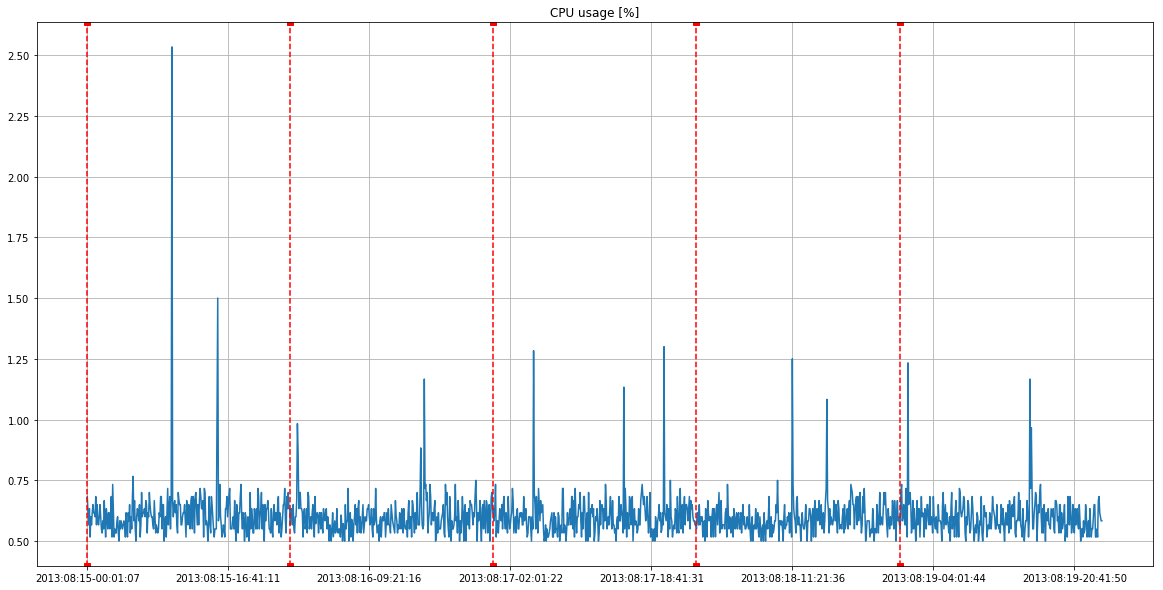

In [42]:
plt.figure(figsize=(20,10))
df1 = df[(df.index>'2013:08:15-00:00:00') & (df.index<'2013:08:20-00:00:00')]['CPU usage [%]']
df1.plot()

curr_day = 15
i, curr_date = 0, "2013:08:{}-00:00:00".format(curr_day)
while i < df1.shape[0]:
    if df1.index[i] >= curr_date:
        plt.axvline(i, c= 'r', marker='s', linestyle='--')
        curr_day += 1
        curr_date = "2013:08:{}-00:00:00".format(curr_day)
    i += 1
        
plt.title('CPU usage [%]')
plt.grid(True)
plt.show()

<a href='#toc'>Назад к Оглавлению</a>

# Построение нейронной сети <a name='build'></a>

In [43]:
wl = 10

In [60]:
model = Sequential()
model.add(LSTM(wl, input_shape=(None, 10)))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 972
Trainable params: 972
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
X = []
for i in range(len(df1)-wl):
    X.append(df1.values[i:i+wl])
X = np.array(X)
X = X.reshape(len(X), 1, 10)

y = []
for i, j in zip(df1.index[:], df1.index[wl:]):
    if df1[i:j].mean() > df1.mean():
        y.append(1)
    else:
        y.append(0)
y = np.array(y)

y = tf.keras.utils.to_categorical(y)

In [64]:
X.shape, y.shape

((1430, 1, 10), (1430, 2))

In [66]:
model.fit(X, y, epochs=10, verbose=1)

Epoch 1/10
45/45 [==============================] - 0s 703us/step - loss: 0.6646 - accuracy: 0.6140
Epoch 2/10
45/45 [==============================] - 0s 691us/step - loss: 0.6646 - accuracy: 0.6140
Epoch 3/10
45/45 [==============================] - 0s 713us/step - loss: 0.6645 - accuracy: 0.6140
Epoch 4/10
45/45 [==============================] - 0s 773us/step - loss: 0.6643 - accuracy: 0.6140
Epoch 5/10
45/45 [==============================] - 0s 702us/step - loss: 0.6642 - accuracy: 0.6140
Epoch 6/10
45/45 [==============================] - 0s 684us/step - loss: 0.6639 - accuracy: 0.6140
Epoch 7/10
45/45 [==============================] - 0s 699us/step - loss: 0.6638 - accuracy: 0.6140
Epoch 8/10
45/45 [==============================] - 0s 693us/step - loss: 0.6637 - accuracy: 0.6140
Epoch 9/10
45/45 [==============================] - 0s 704us/step - loss: 0.6636 - accuracy: 0.6140
Epoch 10/10
45/45 [==============================] - 0s 709us/step - loss: 0.6633 - accuracy: 0.6140

In [50]:
predict = model.predict(X)

In [51]:
predict.shape

(1430, 2)

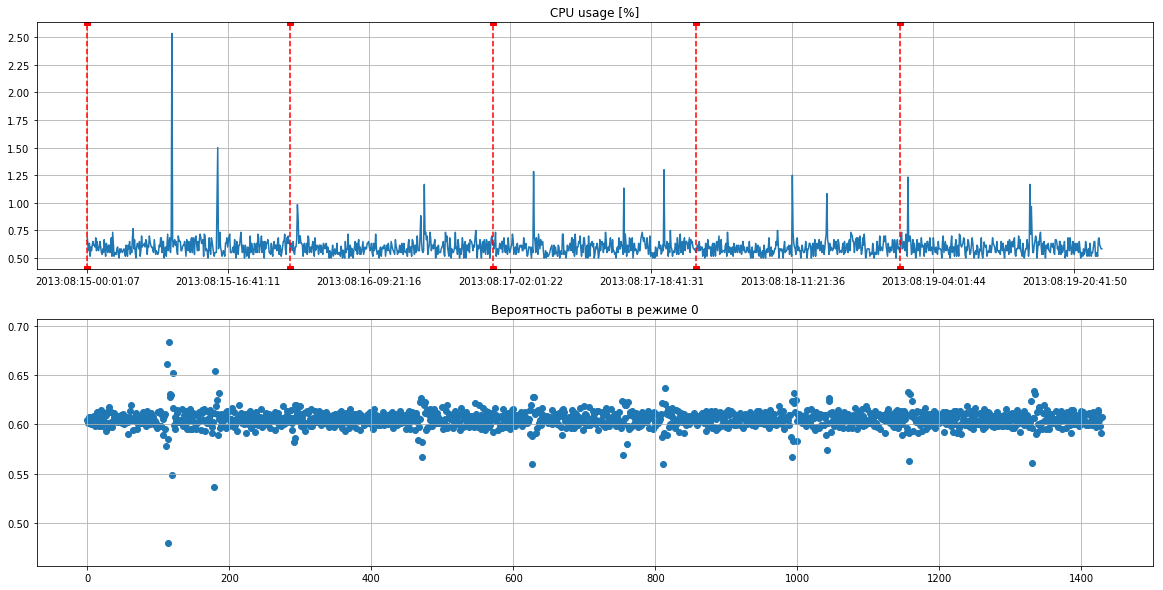

In [52]:
plt.figure(figsize=(20,10))
df1 = df[(df.index>'2013:08:15-00:00:00') & (df.index<'2013:08:20-00:00:00')]['CPU usage [%]']

plt.subplot(211)
df1.plot()
curr_day = 15
i, curr_date = 0, "2013:08:{}-00:00:00".format(curr_day)
while i < df1.shape[0]:
    if df1.index[i] >= curr_date:
        plt.axvline(i, c= 'r', marker='s', linestyle='--')
        curr_day += 1
        curr_date = "2013:08:{}-00:00:00".format(curr_day)
    i += 1
plt.title('CPU usage [%]')
plt.grid(True)

plt.subplot(212)
plt.scatter(range(predict.shape[0]), predict[:,0])    
plt.title('Вероятность работы в режиме 0')
plt.grid(True)
plt.show()

<a href='#toc'>Назад к Оглавлению</a>

# Применение модели для анализа всего датасета <a name='prediction'></a>

In [53]:
model.predict(np.array(df1.values[0:10]).reshape(1,1,10))

array([[0.6045206 , 0.39547938]], dtype=float32)

In [54]:
X_all = []
for i in range(len(df)-wl):
    X_all.append(df['CPU usage [%]'].values[i:i+wl])
X_all = np.array(X_all)
X_all = X_all.reshape(len(X_all), 1, 10)

y_all = []
for i, j in zip(df.index[:], df.index[wl:]):
    if df['CPU usage [%]'][i:j].mean() > df['CPU usage [%]'].mean():
        y_all.append(1)
    else:
        y_all.append(0)
y_all = np.array(y_all)

y_all = tf.keras.utils.to_categorical(y_all)

In [55]:
X_all.shape

(8624, 1, 10)

In [56]:
predict_all = model.predict(X_all)

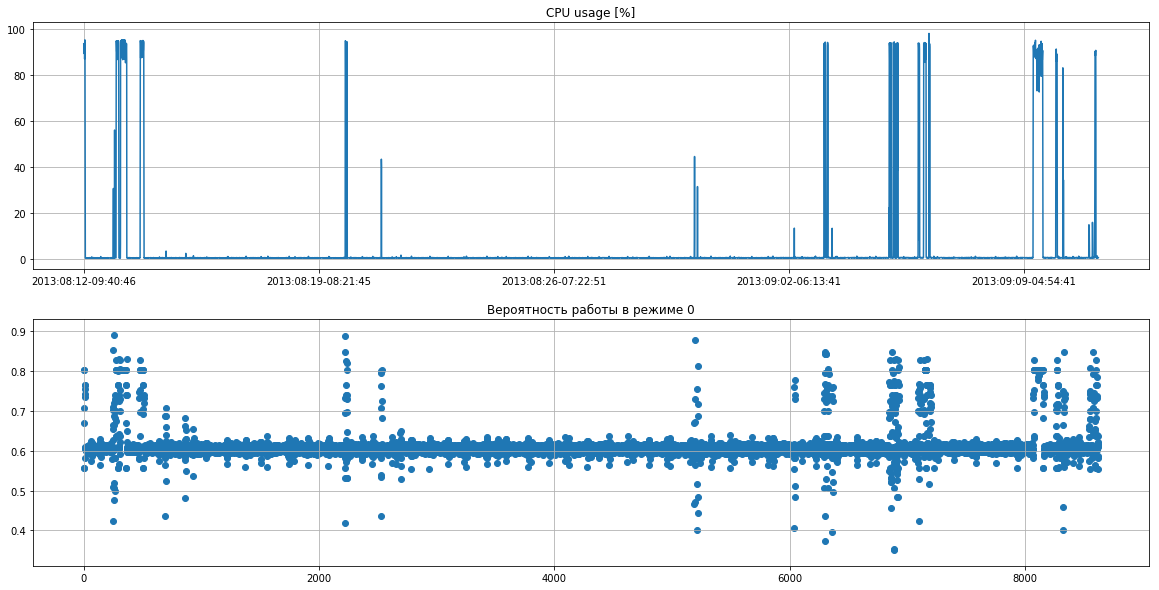

In [57]:
plt.figure(figsize=(20,10))

plt.subplot(211)
df['CPU usage [%]'].plot()
plt.title('CPU usage [%]')
plt.grid(True)

plt.subplot(212)
plt.scatter(range(predict_all.shape[0]), predict_all[:,0])
plt.title('Вероятность работы в режиме 0')
plt.grid(True)
plt.show()

In [58]:
X_all.shape

(8624, 1, 10)

<a href='#toc'>Назад к Оглавлению</a>

# Полезные ссылки <a name='links'></a>

- https://toolbox.google.com/datasetsearch

- https://github.com/sevaiq/Datacenter_dataset

- https://www.tensorflow.org/guide/keras/rnn

- https://habr.com/ru/post/487808/

<a href='#toc'>Назад к Оглавлению</a>